In [3]:
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import keras.datasets.fashion_mnist as fashion_mnist
import tensorflow as tf
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from sklearn.model_selection import train_test_split
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.layers import concatenate
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout, AveragePooling2D, GlobalAveragePooling2D

In [4]:
(train_x, train_y), (test_x, test_y) = fashion_mnist.load_data()

train_x = np.expand_dims(train_x, axis=-1)
train_x = tf.image.resize(train_x, [84,84]).numpy()
#x_train = np.repeat(x_train, 3, axis=3)
test_x = np.expand_dims(test_x, axis=-1)
test_x = tf.image.resize(test_x, [84,84]).numpy()
#x_test = np.repeat(x_test, 3, axis=3)
train_y = train_y.astype('int')
test_y = test_y.astype('int')

print('Training', train_x.shape, train_x.max())
print('Testing', test_x.shape, test_x.max())

4431872/4422102 [==============================] - 0s 0us/step
Training (60000, 84, 84, 1) 255.0
Testing (10000, 84, 84, 1) 255.0


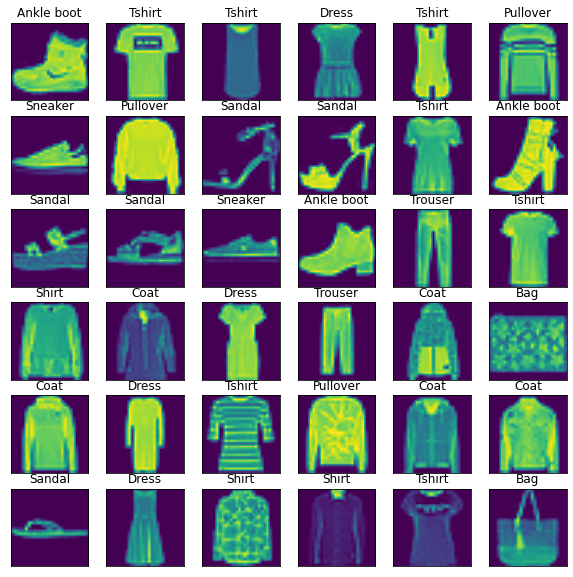

In [5]:
class_names= ['Tshirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_x[i].reshape((84,84)))
    label_index= int(train_y[i])
    plt.title(class_names[label_index])
plt.show()

In [6]:
train_groups = [train_x[np.where(train_y==i)[0]] for i in np.unique(train_y)]
test_groups = [test_x[np.where(test_y==i)[0]] for i in np.unique(train_y)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [11]:
def build_siamese_model(feature_model):
  first_img_input = tf.keras.layers.Input(shape=train_x.shape[1:], name = 'first_img_input')
  second_img_input = tf.keras.layers.Input(shape=train_x.shape[1:], name = 'second_img_input')
  first_img_features = feature_model(first_img_input)
  second_img_features = feature_model(second_img_input)
  combined_features = tf.keras.layers.concatenate([first_img_features, second_img_features], name='merge_features')
  combined_features = tf.keras.layers.Dense(16, activation = 'linear')(combined_features)
  combined_features = tf.keras.layers.BatchNormalization()(combined_features)
  combined_features = tf.keras.layers.Activation('relu')(combined_features)
  combined_features = tf.keras.layers.Dense(4, activation = 'linear')(combined_features)
  combined_features = tf.keras.layers.BatchNormalization()(combined_features)
  combined_features = tf.keras.layers.Activation('relu')(combined_features)
  combined_features = tf.keras.layers.Dense(1, activation = 'sigmoid')(combined_features)
  model = tf.keras.Model(inputs = [first_img_input, second_img_input], outputs=[combined_features], name = 'Siamese_model')
  return model

In [12]:
def gen_random_batch(in_groups, batch_halfsize = 8):
  out_img_a, out_img_b, out_score = [], [], []
  all_groups = list(range(len(in_groups)))
  for match_group in [True, False]:
    group_idx = np.random.choice(all_groups, size = batch_halfsize)
    out_img_a += [in_groups[c_idx]
[np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]

    if match_group:
      b_group_idx = group_idx
      out_score += [1]*batch_halfsize
    else:
      # anything but the same group
      non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx]
      b_group_idx = non_group_idx
      out_score += [0]*batch_halfsize
    out_img_b += [in_groups[c_idx]
[np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
  return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

In [13]:
base_model = InceptionResNetV2(weights=None, include_top=False, input_shape=(84, 84, 1), classes=10)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(36, activation='relu')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [14]:
similarity_model = build_siamese_model(model)
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])

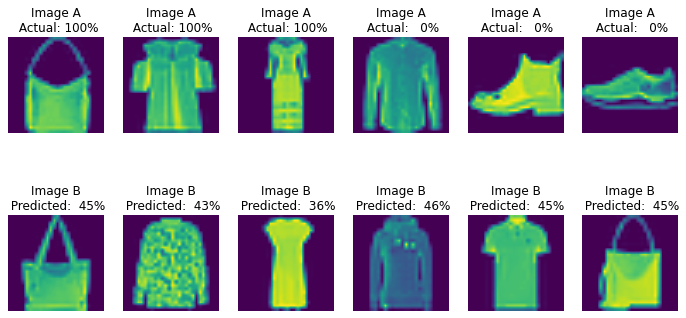

In [15]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
      ax1.imshow(c_a[:,:,0])
      ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
      ax1.axis('off')
      ax2.imshow(c_b[:,:,0])
      ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
      ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [16]:
# make a generator out of the data
def siam_gen(in_groups, batch_size = 32):
  while True:
    pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
    yield [pv_a, pv_b], pv_sim
# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(siam_gen(train_groups),
                                            steps_per_epoch = 500,
                                            validation_data=([valid_a, valid_b], valid_sim),
                                            epochs = 10,
                                            verbose = True)


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


500/500 [==============================] - 362s 626ms/step - loss: 0.5486 - mae: 0.3922 - val_loss: 0.4579 - val_mae: 0.3412
Epoch 2/10
500/500 [==============================] - 315s 630ms/step - loss: 0.4386 - mae: 0.3183 - val_loss: 0.4059 - val_mae: 0.2942
Epoch 3/10
500/500 [==============================] - 295s 590ms/step - loss: 0.4005 - mae: 0.2814 - val_loss: 0.3945 - val_mae: 0.2711
Epoch 4/10
500/500 [==============================] - 293s 587ms/step - loss: 0.3717 - mae: 0.2566 - val_loss: 0.3664 - val_mae: 0.2456
Epoch 5/10
500/500 [==============================] - 293s 586ms/step - loss: 0.3539 - mae: 0.2375 - val_loss: 0.3643 - val_mae: 0.2397
Epoch 6/10
500/500 [==============================] - 293s 586ms/step - loss: 0.3499 - mae: 0.2307 - val_loss: 0.3330 - val_mae: 0.2117
Epoch 7/10
500/500 [==============================] - 293s 586ms/step - loss: 0.3390 - mae: 0.2192 - val_loss: 0.3252 - val_mae: 0.2046
Epoch 8/10
500/500 [==============================] - 293s 

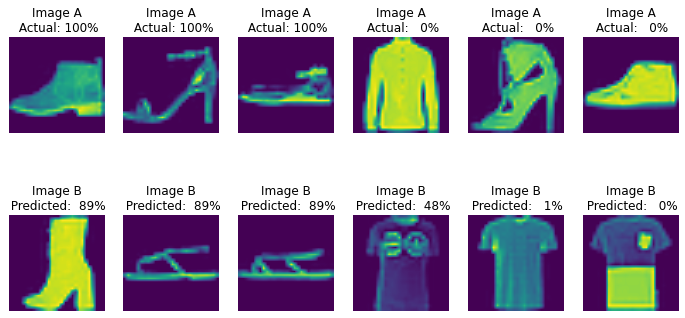

In [17]:
_ = show_model_output()

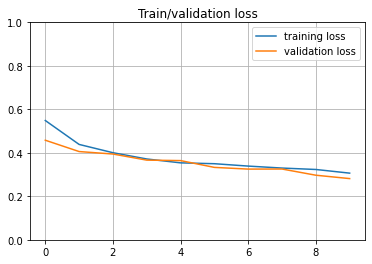

In [18]:
def plot_history(history):
    plt.title('Train/validation loss')
    plt.plot(history.history['loss'], label = 'training loss')
    plt.plot(history.history['val_loss'], label = 'validation loss')
    plt.grid()
    plt.legend()
    plt.ylim(0,1)
    plt.show()

plot_history(loss_history)

In [21]:
def find_similar(image, images, count=3, threshold=50):
    pv_a, pv_b = np.reshape([image]*len(images), (len(images), 84,84)), np.reshape(images, (len(images), 84,84))
    pred_sim = similarity_model.predict([pv_a, pv_b]).ravel()
    indxs = np.argsort(pred_sim)[::-1][:count]
    
    fig, m_axs = plt.subplots(2, count, figsize = (12, 6))
    i = 0
    for c_a, (ax1, ax2) in zip(pv_a[:count], m_axs.T):
        
        ax1.imshow(c_a)
        ax1.set_title('Input image\n')
        ax1.axis('off')
        ax2.imshow(pv_b[indxs[i]])
        ax2.set_title('Similar\n Predicted: %3.0f%%' % (100*pred_sim[indxs[i]]))
        ax2.axis('off')
        i += 1

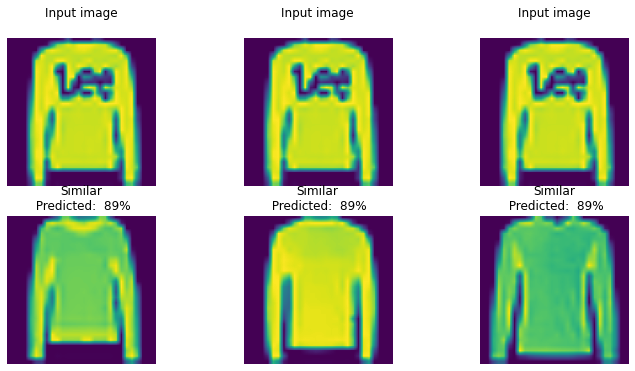

In [22]:
find_similar(test_x[1], images=test_x[1:100])

In [23]:
x_test_features = model.predict(test_x, verbose = True, batch_size=128)

79/79 [==============================] - 20s 180ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...
[t-SNE] Computed neighbors for 10000 samples in 3.892s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 7.169514
[t-SNE] Computed conditional probabilities in 0.693s


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 53.6990204, gradient norm = 0.0166566 (50 iterations in 5.110s)
[t-SNE] Iteration 100: error = 53.9315109, gradient norm = 0.0118138 (50 iterations in 4.360s)
[t-SNE] Iteration 150: error = 54.2980881, gradient norm = 0.0079092 (50 iterations in 4.158s)
[t-SNE] Iteration 200: error = 54.3200073, gradient norm = 0.0069904 (50 iterations in 4.034s)
[t-SNE] Iteration 250: error = 54.7108917, gradient norm = 0.0051823 (50 iterations in 4.067s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.710892
[t-SNE] Iteration 300: error = 1.0423901, gradient norm = 0.0007222 (50 iterations in 4.270s)
[t-SNE] Iteration 350: error = 0.9178526, gradient norm = 0.0003337 (50 iterations in 4.564s)
[t-SNE] Iteration 400: error = 0.8487687, gradient norm = 0.0002425 (50 iterations in 4.583s)
[t-SNE] Iteration 450: error = 0.8010902, gradient norm = 0.0001849 (50 iterations in 4.637s)
[t-SNE] Iteration 500: error = 0.7685200, gradient norm = 0.0001416 (50 

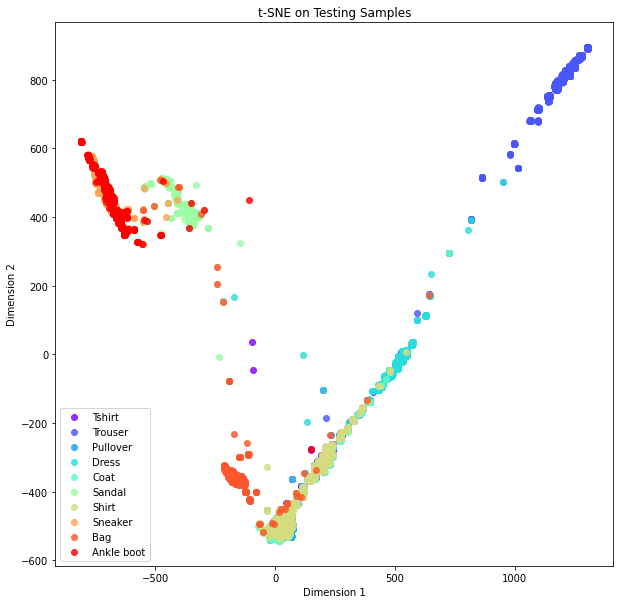

CPU times: user 1min 23s, sys: 2.45 s, total: 1min 26s
Wall time: 50.3 s


In [24]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
        init='pca',
        random_state=101,
        method='barnes_hut',
        n_iter=500,
        verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, class_names)):
    plt.scatter(tsne_features[np.where(test_y == c_group), 0],
    tsne_features[np.where(test_y == c_group), 1],
    marker='o',
    color=c_color,
    linewidth='1',
    alpha=0.8,
    label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)